# iForest

In [1]:
import warnings
warnings.filterwarnings('ignore')

## General libraries

In [2]:
import os
import sys

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from os.path import join
import json
import datetime

import shap
from shap_selection import feature_selection

from sklearn.preprocessing import OneHotEncoder
import time

### Load enviroment variables

In [3]:
from dotenv import load_dotenv
load_dotenv('../.env')

code_root = os.environ['CODE_ROOT']
cfg_path = os.environ['CFG_PATH']
data_root = os.environ['DATA_ROOT']

sys.path.insert(0, code_root)

### Specific libraries

In [4]:
from src.load.functions import get_fs_dataset, fs_datasets_hyperparams
from src.plots.functions import plot_3d_surface, plot_2d_surface, boxplot_stability, lineplot_stability
from src.utils.functions import add_custom_repeating_sequence, add_sequence_to_dataframe, prepare_subsets
from src.optimization.functions import opt_value

# if we want to create an iteractive plot or not
from mpl_toolkits.mplot3d import Axes3D
%matplotlib widget

## Parameters

In [5]:
import os
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Patch


import os
import pandas as pd
import numpy as np

def process_data(dataset_id, df):
    """
    Processes SHAP data files by reading them, filtering, and calculating additional metrics including the interquartile range (IQR).
    
    Parameters:
    - dataset_id: The unique identifier for the dataset.
    - data_root: The root directory where the data files are located.
    
    Returns:
    - df: The processed pandas DataFrame containing selected variables and calculated metrics.
    """

    # Filter dataframe
    df = df[(df.n_estimators >= 25) & (df.n_estimators <= 300)]
    
    # Calculate percentiles, stability index, and IQR
    df['shap_q1'] = df['stab_shap'].apply(lambda x: np.percentile(x, 25))  # Lower quartile (25th percentile)
    df['shap_q2'] = df['stab_shap'].apply(lambda x: np.percentile(x, 50))  # Median (50th percentile)
    df['shap_q3'] = df['stab_shap'].apply(lambda x: np.percentile(x, 75))  # Upper quartile (75th percentile)
    df['stability index'] = df['stab_shap'].apply(lambda x: np.mean(x))
    df['IQR'] = df['stab_shap'].apply(lambda x: np.percentile(x, 75) - np.percentile(x, 25))  # Interquartile range (Q3 - Q1)
    df['dataset'] = dataset_id
    df['hpo'] = np.where((df.n_estimators == 100) & (df.max_feats == df.max_feats.max()),
        'Benchmark',
        'Our model')

    # Select variables to keep
    df.rename(columns={'f1-score': 'f1_score'}, inplace=True)
    
    var = ['dataset', 'hpo', 'n_estimators', 'max_feats', 'n_feats', 
           'f1_score', 'precision', 'recall', 'stab_model', 'stab_shap', 
           'shap_q1', 'shap_q2', 'shap_q3', 'stability index', 'IQR', 'roc_auc']
    df = df[var]

    return df


def filter_and_select(df, fi_shap_all, boxplot=False, factor=0.99):
    """
    Filters and selects rows from a DataFrame based on specified conditions.
    
    Parameters:
    - df: A pandas DataFrame containing model evaluation metrics and parameters.
    
    Returns:
    - df_filtered: A filtered DataFrame based on the conditions.
    """
    # Define the variables of interest
    #var = ['dataset', 'hpo', 'n_estimators', 'n_feats', 'max_feats', 'roc_auc', 'precision', 'recall', 'f1_median', 'stability index', 'shap_stab']
    #df = df[var]

    #filter_shap = int(fi_shap_all[fi_shap_all.cum_value_percentage<99.9].n_feats.tail(1))

    df1_1 = df[df.hpo == 'Benchmark'].head(1)
    # Extract specific metrics from df1_1
    roc = df1_1.roc_auc.iloc[0] * factor
    precision = df1_1.precision.iloc[0] * factor
    recall = df1_1.recall.iloc[0] * factor
    f1_score = df1_1['f1_score'].iloc[0] * factor
    stability = df1_1['stability index'].iloc[0]
    IQR = df1_1['IQR'].iloc[0]
    n_features = df1_1.n_feats.iloc[0]

    # baseline = {'f1_score': f1_score, 'precision': precision, 'recall': recall, 'roc_auc': roc}
    baseline = {'precision': precision, 'roc_auc': roc}
    df1_2 = df[df.hpo != 'Benchmark']
    #criteria = np.where(df1_1.n_feats>=25, False, True)
    df1_2 = df1_2[df1_2['stability index'] >= stability]
    if n_features >= 10:
        df1_2 = df1_2[(df1_2.n_feats < n_features)]
    df1_2 = find_best_row_by_distance_and_stability(df1_2, 
                                                    baseline, 
                                                    stability_col='stability index',
                                                    IQR_col='IQR',
                                                    IQR_base=IQR,
                                                    distance_weight=1, 
                                                    stability_weight=0.3, 
                                                    threshold=np.inf)

    # Extract specific feature numbers
    dataframes = [df1_1, df1_2]
    df = pd.concat(dataframes)
    #df = df.drop_duplicates()

    return df


def find_best_row_by_distance_and_stability(df, baseline, stability_col='stability', IQR_col='IQR', IQR_base=np.inf, distance_weight=1, stability_weight=0.5, threshold=np.inf):
    """
    Finds the best matching row in df based on a combination of closeness to the baseline values, the stability score, IQR filtering,
    and optionally preferring rows with values higher than the baseline.
    
    Parameters:
    - df: DataFrame to search within.
    - baseline: Dictionary specifying baseline values for columns, excluding the stability and IQR columns.
    - stability_col: Name of the column containing stability scores.
    - IQR_col: Name of the column containing IQR values.
    - IQR_base: The maximum allowed IQR value for selection.
    - distance_weight: Weight of the distance score in the final score calculation.
    - stability_weight: Weight of the stability score in the final score calculation.
    - threshold: Maximum allowed final score to consider a row close enough.
    
    Returns:
    - A single-row DataFrame if a suitable row is found; otherwise, None.
    """
    if df.empty:
        return None

    # Check for missing columns
    missing_cols = [col for col in baseline.keys() if col not in df.columns]
    if missing_cols:
        raise ValueError(f"Missing columns in DataFrame: {missing_cols}")
    if stability_col not in df.columns or IQR_col not in df.columns:
        raise ValueError(f"Missing required columns in DataFrame")

    # First, try to filter rows with IQR <= IQR_base
    df_IQR_filtered = df[df[IQR_col] <= IQR_base]

    # If no rows fulfill the IQR requirement
    if df_IQR_filtered.empty:
        df_IQR_filtered = df
        baseline['IQR'] = IQR_base

    # First, try to filter rows with metrics >= baseline
    for metric, baseline_value in baseline.items():
        df_baseline_filtered = df_IQR_filtered[df_IQR_filtered[metric] >= baseline_value]
    
    # If no rows fulfill the metrics >= baseline requirement
    if df_baseline_filtered.empty:
        df_baseline_filtered = df_IQR_filtered
    
    # Compute the "distance" for each row in the filtered DataFrame
    distance = df_baseline_filtered.apply(lambda row: np.sqrt(sum((row[baseline.keys()] - pd.Series(baseline))**2)), axis=1)

    # Normalize distance and stability scores to [0, 1]
    distance_norm = (distance - distance.min()) / (distance.max() - distance.min())
    stability_norm = (df_baseline_filtered[stability_col] - df_baseline_filtered[stability_col].min()) / (df_baseline_filtered[stability_col].max() - df_baseline_filtered[stability_col].min())

    # Calculate combined score
    final_score = distance_weight * distance_norm - stability_weight * stability_norm

    # Find the row with the minimum final score within the threshold
    best_idx = final_score.idxmin()

    if final_score[best_idx] <= threshold:
        return df_baseline_filtered.loc[[best_idx]]
    else:
        return None


def process_graph_data(df):
    """
    Processes SHAP data files by reading them, filtering, and calculating additional metrics.
    
    Parameters:
    - dataset_id: The unique identifier for the dataset.
    - data_root: The root directory where the data files are located.
    
    Returns:
    - df: The processed pandas DataFrame containing selected variables and calculated metrics.
    """
    # Find the index of the maximum 'n_feat' in each 'n_estimators' and 'n_feats' group
    idx = df.groupby(['n_estimators', 'n_feats'])['max_feats'].idxmax()
    # Filter the DataFrame to keep only the rows with the maximum 'n_feat' per group
    df = df.loc[idx].reset_index(drop=True)

    return df


def append_dataframes(dataframes):
    """
    Appends a list of DataFrames into a single DataFrame.
    
    Parameters:
    - dataframes: List of pandas DataFrames with the same format.
    
    Returns:
    - A single DataFrame containing all rows from the input DataFrames.
    """
    # Concatenate the DataFrames row-wise
    combined_df = pd.concat(dataframes, ignore_index=True)
    return combined_df

## Visualization of the results

In [6]:
import os
import pandas as pd

# Assuming 'data_root', 'process_data', 'append_dataframes', 'filter_and_select', 
# and 'process_graph_data' are defined elsewhere in your code.

# List of dataset identifiers
dataset_ids = ['arrhythmia', 'creditcard', 'musk', 'cardio', 'bank', 'mammography']

# Initialize lists to store dataframes
processed_dataframes = []
filtered_dataframes = []
graph_dataframes = []

# Loop through each dataset ID
for dataset_id in dataset_ids:
    # Construct file paths for SHAP values and feature importances
    path_shap = os.path.join(data_root, "outputs", f"{dataset_id}_shap.parquet")
    path_fi_shap = os.path.join(data_root, "outputs", f"{dataset_id}_fi_shap")
    
    # Read the parquet files
    df = pd.read_parquet(path_shap)
    fi_shap_all = pd.read_parquet(path_fi_shap)

    # Process the data
    processed_df = process_data(dataset_id, df)
    processed_dataframes.append(processed_df)
    
    # Filter and select data
    filtered_df = filter_and_select(processed_df, fi_shap_all, factor=1.0)
    filtered_dataframes.append(filtered_df)
    
    # Prepare graph data
    graph_df = process_graph_data(processed_df)
    graph_dataframes.append(graph_df)

# Append processed dataframes into a single dataframe
df = append_dataframes(processed_dataframes)

# Append filtered dataframes into a single dataframe for the group analysis
df_group = append_dataframes(filtered_dataframes)
var = ['dataset', 'hpo', 'n_estimators', 'max_feats', 'n_feats', 'roc_auc', 'precision', 'recall', 'f1_score',
       'stab_model', 'stability index', 'shap_q1', 'shap_q2', 'shap_q3', 'IQR', 'stab_shap']
df_group = df_group[var].round(4)

# Perform an inner join based on 'dataset', 'n_estimators', 'max_feats', and 'n_feats'
var = ['dataset', 'max_feats', 'n_feats']
df_benchmark = pd.merge(df, df_group[var][df_group.hpo=='Benchmark'], on=var, how='inner')
df_benchmark['hpo'] = 'Benchmark'
df_our_model = pd.merge(df, df_group[var][df_group.hpo=='Our model'], on=var, how='inner')
df_our_model['hpo'] = 'Our model'
df = df_benchmark.append(df_our_model, ignore_index=True)


# The graph dataframes are already prepared in the loop

In [7]:
df_group[['dataset', 'hpo', 'n_estimators', 'max_feats', 'n_feats', 'roc_auc', 'precision', 'recall', 'f1_score', 'stab_model', 'stability index', 'shap_q1', 'shap_q2', 'shap_q3', 'IQR']]

,dataset,hpo,n_estimators,max_feats,n_feats,roc_auc,precision,recall,f1_score,stab_model,stability index,shap_q1,shap_q2,shap_q3,IQR
0,arrhythmia,Benchmark,100,257,257,0.8119,0.5238,0.4231,0.4681,0.9698,0.5735,0.5559,0.5672,0.5846,0.0288
1,arrhythmia,Our model,200,235,235,0.8206,0.5217,0.4615,0.4898,0.9788,0.6512,0.6222,0.6427,0.6678,0.0456
2,creditcard,Benchmark,100,28,28,0.9432,0.0149,0.8680,0.0293,0.9719,0.7105,0.6506,0.7156,0.7734,0.1228
3,creditcard,Our model,200,24,24,0.9434,0.0149,0.8680,0.0294,0.9821,0.8236,0.7839,0.8329,0.8745,0.0906
4,musk,Benchmark,100,166,166,1.0000,0.3197,1.0000,0.4845,0.9419,0.5506,0.5214,0.5484,0.5801,0.0586
5,musk,Our model,50,74,74,0.9900,0.3145,1.0000,0.4785,0.9404,0.6104,0.5825,0.6099,0.6391,0.0566
6,cardio,Benchmark,100,21,21,0.9196,0.5000,0.5286,0.5139,0.9750,0.8222,0.7789,0.8288,0.8710,0.0920
7,cardio,Our model,200,8,14,0.9234,0.5211,0.5286,0.5248,0.9863,0.9053,0.8763,0.9116,0.9403,0.0640
8,bank,Benchmark,100,10,10,0.5719,0.2158,0.1843,0.1988,0.9888,0.9594,0.9471,0.9636,0.9754,0.0283
9,bank,Our model,125,3,8,0.5865,0.2166,0.1843,0.1991,0.9953,0.9810,0.9719,0.9858,0.9934,0.0215


In [ ]:
df_group[['dataset', 'hpo', 'n_estimators', 'max_feats', 'n_feats', 'roc_auc', 'precision', 'recall', 'f1_score', 'stab_model', 'stability index', 'shap_q1', 'shap_q2', 'shap_q3', 'IQR']]

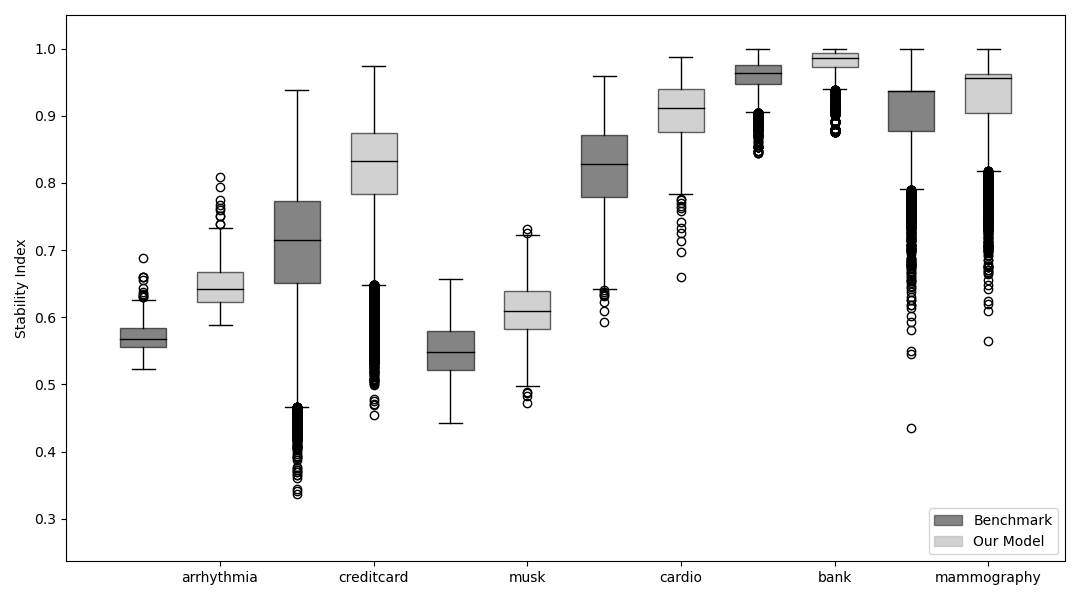

In [8]:
# Example usage
image_1 =  '../boxplots.png'
boxplot_stability(df_group, size=1)
plt.savefig(image_1, bbox_inches='tight', pad_inches=0.1)  #Save the plot to a file

In [9]:
import pandas as pd
import numpy as np

df_all_list = []  # Use a list to collect DataFrames
df_all = []
df_filter = []

for name in dataset_ids:
    df_benchmark = df_group[(df_group['dataset'] == name) & (df_group['hpo'] == 'Benchmark')].iloc[0]
    df_our_model = df_group[(df_group['dataset'] == name) & (df_group['hpo'] != 'Benchmark')].iloc[0]

    df_filter = df[((df['dataset'] == name) & (df['max_feats'] == int(df_benchmark['max_feats'])) & (df['n_feats'] == int(df_benchmark['n_feats']))) | 
                   ((df['dataset'] == name) & (df['max_feats'] == int(df_our_model['max_feats'])) & (df['n_feats'] == int(df_our_model['n_feats'])))]

    df_filter = df_filter.copy()  # Avoid SettingWithCopyWarning
    df_filter['hpo'] = np.where(((df_filter.max_feats==int(df_benchmark.max_feats)) & (df_filter.n_feats==int(df_benchmark.n_feats))), 'Benchmark', 'Our model')

    df_all_list.append(df_filter)

# Concatenate all DataFrames outside the loop
df_all = pd.concat(df_all_list, ignore_index=True)


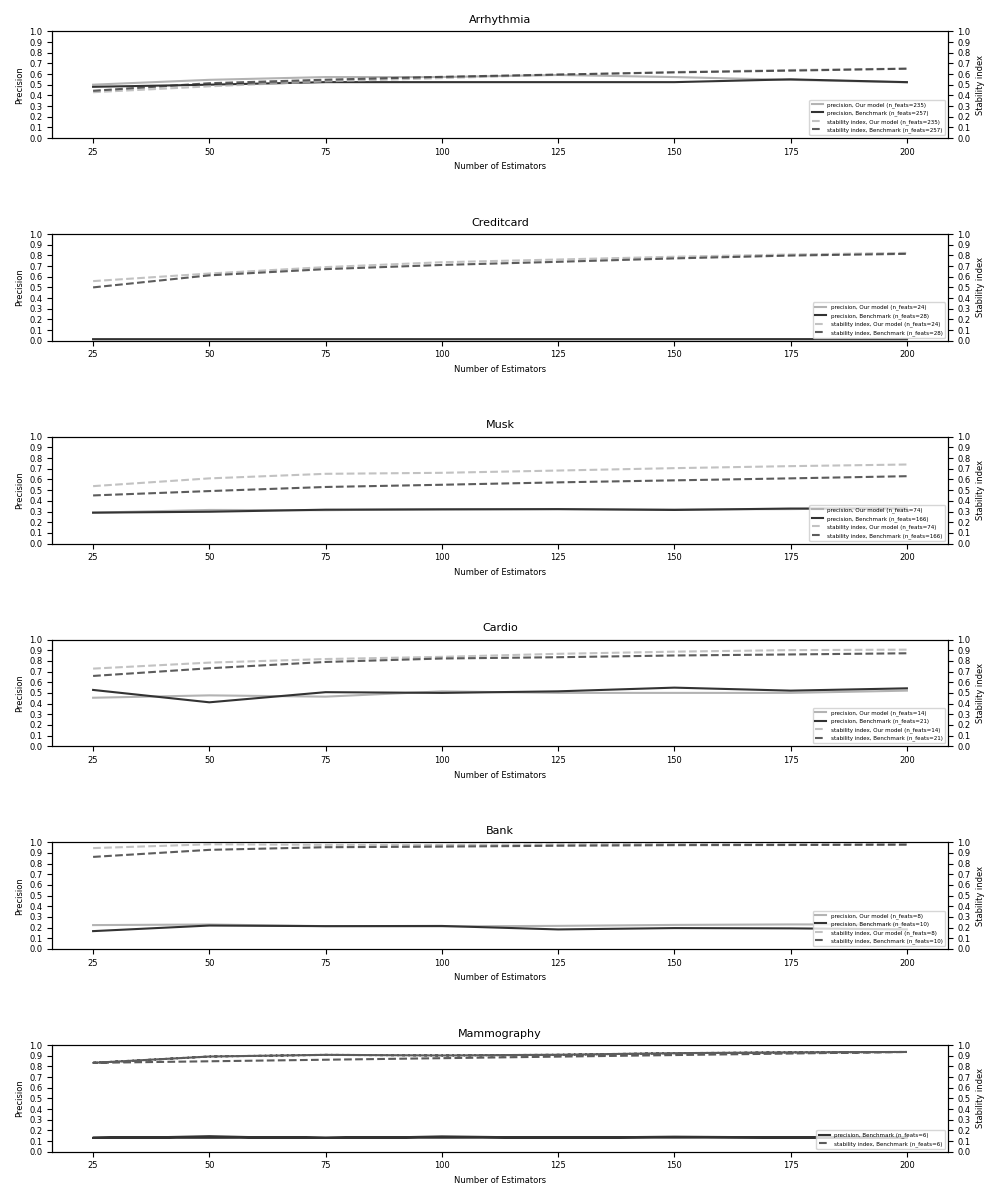

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 12))  # Overall figure size

# Assuming col and row represent the number of columns and rows of subplots you want
col, row = 6, 1

# Loop through each dataset_id to create a subplot for each
for i, dataset_id in enumerate(dataset_ids, start=1):
    ax = plt.subplot(col, row, i)
    # Filter df_all for the current dataset_id and plot
    filtered_df = df_all[df_all.dataset == dataset_id]
    lineplot_stability(filtered_df, ax, primary_feat='precision', secondary_feat='stability index')

plt.tight_layout()  # Adjust layout to prevent overlap
plt.subplots_adjust(wspace=0.1, hspace=0.9)  # Adjust the spacing as needed

# Save the plot to a file
image_2 = '../comparison.png'
plt.savefig(image_2, bbox_inches='tight', pad_inches=0.1)

plt.show()

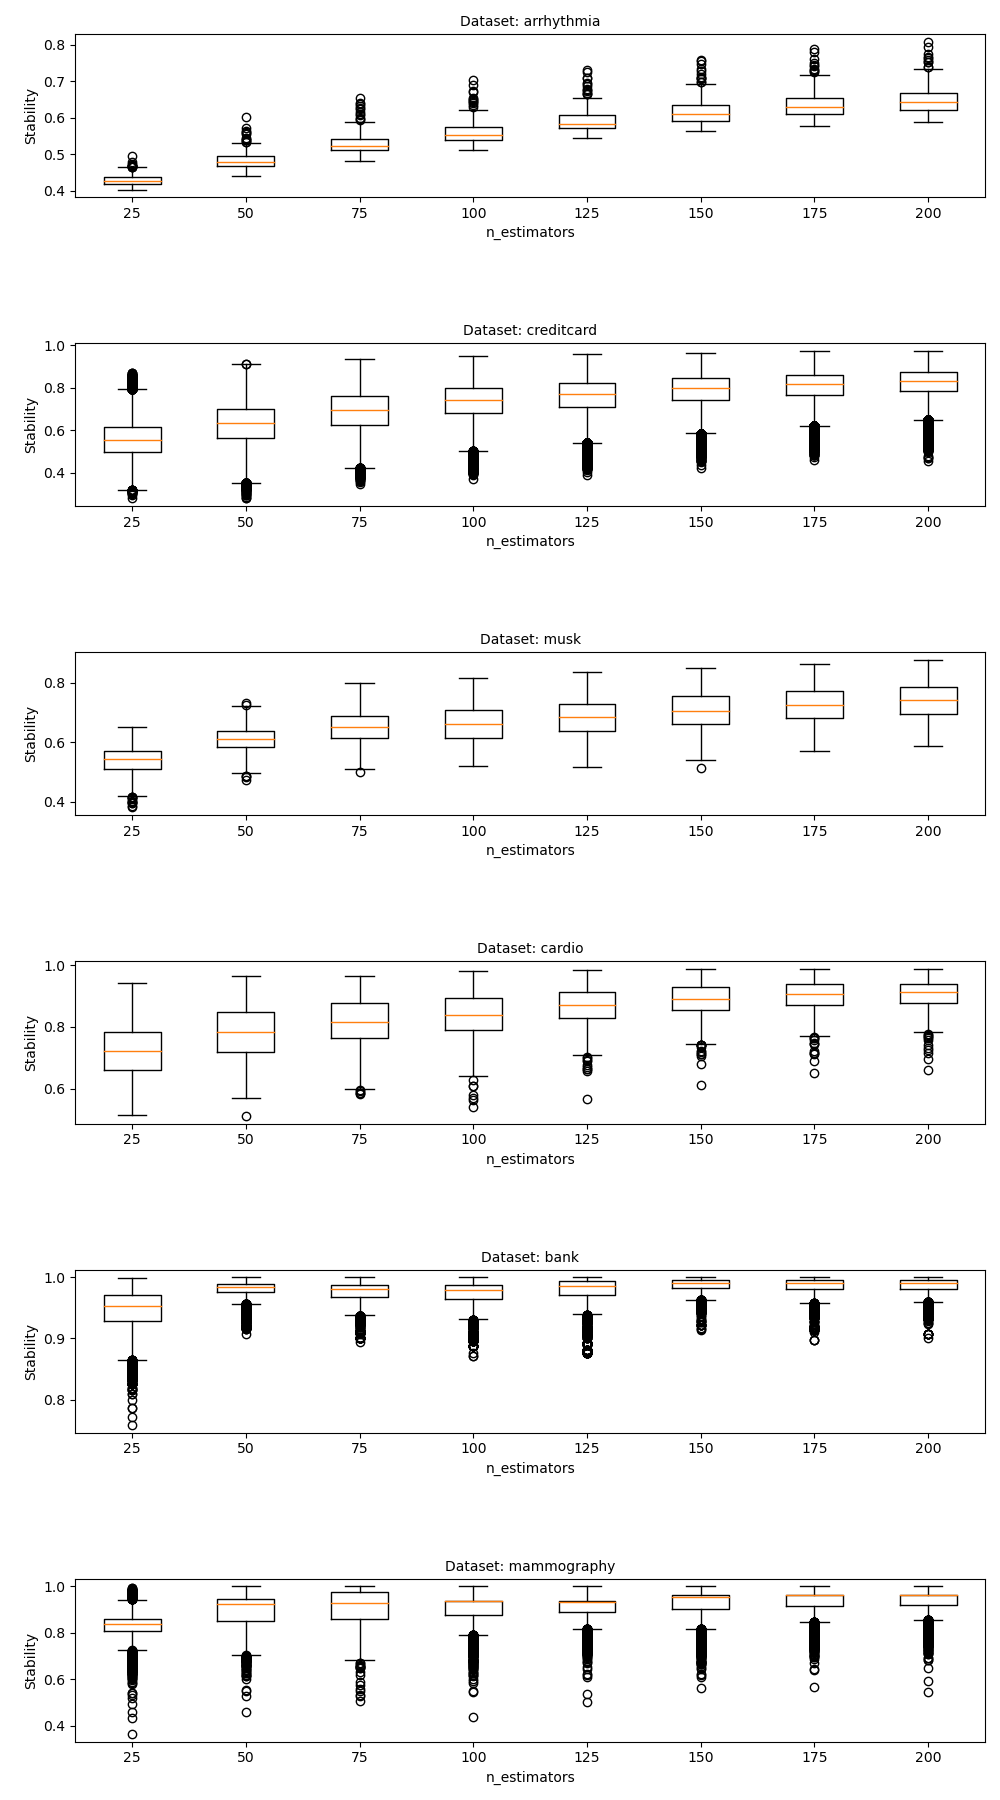

In [11]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(10, 18))  # Overall figure size

col, row = 6, 1  # Number of columns and rows for subplots

for i, dataset_id in enumerate(dataset_ids, start=1):
    ax = plt.subplot(col, row, i)
    
    # Filter the DataFrame for the current dataset and model
    current_df = df[(df.dataset == dataset_id) & (df.hpo == 'Our model')]
    
    # Assuming 'stab_shap' is what you want to boxplot
    ax.boxplot(current_df['stab_shap'])
    
    # Set y-axis from 0 to 1
    # ax.set_ylim([0.3, 1])
    
    # Set x-axis labels to n_estimators values
    # This assumes you have the same number of n_estimators for each dataset_id. 
    # If not, you might need to adjust this part.
    ax.set_xticklabels(current_df['n_estimators'].unique(), rotation=0, ha="center")
    
    # Add a small title for each subplot
    ax.set_title(f"Dataset: {dataset_id}", fontsize=10)
    
    # Optional: Set labels for clarity
    ax.set_xlabel("n_estimators")
    ax.set_ylabel("Stability")

plt.tight_layout()  # Adjust layout to prevent overlap
plt.subplots_adjust(wspace=0.1, hspace=0.9)  # Adjust the spacing as needed

# Save the plot to a file
image_2 = '../comparison_boxplots.png'
plt.savefig(image_2, bbox_inches='tight', pad_inches=0.1)

plt.show()


In [12]:
def process_data(dataset_id, df):
    """
    Processes SHAP data files by reading them, filtering, and calculating additional metrics including the interquartile range (IQR).
    
    Parameters:
    - dataset_id: The unique identifier for the dataset.
    - data_root: The root directory where the data files are located.
    
    Returns:
    - df: The processed pandas DataFrame containing selected variables and calculated metrics.
    """

    # Filter dataframe
    df = df[(df.n_estimators >= 25) & (df.n_estimators <= 300)]
    
    # Calculate percentiles, stability index, and IQR
    df['shap_q1'] = df['stab_shap'].apply(lambda x: np.percentile(x, 25))  # Lower quartile (25th percentile)
    df['shap_q2'] = df['stab_shap'].apply(lambda x: np.percentile(x, 50))  # Median (50th percentile)
    df['shap_q3'] = df['stab_shap'].apply(lambda x: np.percentile(x, 75))  # Upper quartile (75th percentile)
    df['stability index'] = df['stab_shap'].apply(lambda x: np.mean(x))
    df['IQR'] = df['stab_shap'].apply(lambda x: np.percentile(x, 75) - np.percentile(x, 25))  # Interquartile range (Q3 - Q1)
    df['dataset'] = dataset_id
    df['hpo'] = np.where((df.n_estimators == 100) & (df.max_feats == df.max_feats.max()),
        'Benchmark',
        'Our model')

    # Select variables to keep
    df.rename(columns={'f1-score': 'f1_score'}, inplace=True)
    
    var = ['dataset', 'hpo', 'n_estimators', 'max_feats', 'n_feats', 
           'f1_score', 'precision', 'recall', 'stab_model', 'stab_shap', 
           'shap_q1', 'shap_q2', 'shap_q3', 'stability index', 'IQR', 'roc_auc']
    df = df[var]

    return df

In [13]:
dataset_id = 'allianz'
#df_names = [dataset_id1, dataset_id2, dataset_id3, dataset_id4, dataset_id5, dataset_id6]

path_shap = os.path.join(data_root, "outputs", f"{dataset_id}_shap.parquet")
path_fi_shap = os.path.join(data_root, "outputs", f"{dataset_id}_fi_shap.parquet")
# Read data
df = pd.read_parquet(path_shap)
fi_shap_all = pd.read_parquet(path_fi_shap)  # Note: fi_shap_all is read but not used in the provided code snippet

df_real = process_data(dataset_id, df)

factor = 1.0
#df_fil_real = filter_and_select(df_real, factor)

var = ['dataset', 'hpo', 'n_estimators', 'max_feats', 'n_feats', 'stability index', 'stab_shap', 'shap_q2', 'stab_model', 'IQR']
#df_group = round(df_fil_real[var],4)

df_graph_real = process_graph_data(df_real)

In [14]:
fi_shap_all

,n_feats,cum_value,cum_value_percentage,n_feats_percentage,feat_selected
0,2,0.561446,12.542027,5.882353,"[C_CAU_50, d_surv_sin_is_weekend_True]"
1,3,0.826335,18.459324,8.823529,"[C_CAU_50, d_surv_sin_is_weekend_True, C_CAU_40]"
2,5,1.305672,29.167147,14.705882,"[C_CAU_50, d_surv_sin_is_weekend_True, C_CAU_4..."
3,7,1.768254,39.500673,20.588235,"[C_CAU_50, d_surv_sin_is_weekend_True, C_CAU_4..."
4,9,2.210064,49.370173,26.470588,"[C_CAU_50, d_surv_sin_is_weekend_True, C_CAU_4..."
5,12,2.754617,61.534850,35.294118,"[C_CAU_50, d_surv_sin_is_weekend_True, C_CAU_4..."
6,15,3.192019,71.305880,44.117647,"[C_CAU_50, d_surv_sin_is_weekend_True, C_CAU_4..."
7,18,3.568851,79.723858,52.941176,"[C_CAU_50, d_surv_sin_is_weekend_True, C_CAU_4..."
8,23,4.064477,90.795552,67.647059,"[C_CAU_50, d_surv_sin_is_weekend_True, C_CAU_4..."
9,34,4.476516,100.000000,100.000000,"[C_CAU_50, d_surv_sin_is_weekend_True, C_CAU_4..."


In [15]:
df_real

,dataset,hpo,n_estimators,max_feats,n_feats,f1_score,precision,recall,stab_model,stab_shap,shap_q1,shap_q2,shap_q3,stability index,IQR,roc_auc
92,allianz,Our model,25,2,2,0.069892,0.502355,0.037559,1.000000,"[1.0, 0.8772582549056281, 0.8772582549056281, ...",0.877258,0.877258,1.000000,0.919903,0.122742,0.499636
93,allianz,Our model,25,2,3,0.152159,0.505633,0.089554,1.000000,"[1.0, 0.8813690597113473, 1.0, 0.8813690597113...",0.881369,1.000000,1.000000,0.941546,0.118631,0.499943
94,allianz,Our model,25,3,3,0.152159,0.505633,0.089554,1.000000,"[1.0, 0.7503725274934712, 1.0, 0.7503725274934...",0.750373,0.873337,1.000000,0.859989,0.249627,0.499943
95,allianz,Our model,25,2,5,0.146263,0.499316,0.085681,0.985966,"[1.0, 1.0, 1.0, 1.0, 1.0, 0.9878637390107314, ...",0.987864,1.000000,1.000000,0.994828,0.012136,0.491030
96,allianz,Our model,25,3,5,0.149920,0.497354,0.088263,0.968803,"[1.0, 0.9628603374480292, 0.9666497976790724, ...",0.963907,0.967516,0.971110,0.969938,0.007203,0.491314
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
455,allianz,Our model,200,7,36,0.167025,0.497672,0.100352,0.995861,"[0.9745108760797612, 0.9632761386950895, 0.967...",0.963445,0.971529,0.978383,0.970196,0.014937,0.493312
456,allianz,Our model,200,14,36,0.169594,0.502894,0.101995,0.994831,"[0.9719719134740982, 0.9651370187816415, 0.948...",0.953619,0.961840,0.970280,0.961403,0.016661,0.494303
457,allianz,Our model,200,21,36,0.169951,0.503468,0.102230,0.993198,"[0.976681523032808, 0.9485755570570157, 0.9490...",0.943718,0.953351,0.962822,0.952795,0.019104,0.493629
458,allianz,Our model,200,28,36,0.168799,0.503203,0.101408,0.994377,"[0.9750556463104201, 0.9512043202091949, 0.940...",0.943699,0.953355,0.962441,0.952584,0.018742,0.493796


In [16]:
group_1 = df_real[var][(df_real.n_estimators==100) & 
                       (df_real.n_feats==df_real.n_feats.max()) & 
                       (df_real.max_feats==df_real.max_feats.max())]

In [17]:
group_1

,dataset,hpo,n_estimators,max_feats,n_feats,stability index,stab_shap,shap_q2,stab_model,IQR
275,allianz,Benchmark,100,36,36,0.925299,"[0.9501613752421596, 0.9096024934545432, 0.913...",0.925959,0.987349,0.036533


In [18]:
group_2 = df_real[var][(df_real.n_feats==34)].sort_values('stability index', ascending=False).head(1)
group_2

,dataset,hpo,n_estimators,max_feats,n_feats,stability index,stab_shap,shap_q2,stab_model,IQR
450,allianz,Our model,200,6,34,0.965882,"[0.9800918800673141, 0.9353644805635424, 0.965...",0.967332,0.995572,0.018239


In [19]:
df_group = append_dataframes([group_1, group_2])
df_group

,dataset,hpo,n_estimators,max_feats,n_feats,stability index,stab_shap,shap_q2,stab_model,IQR
0,allianz,Benchmark,100,36,36,0.925299,"[0.9501613752421596, 0.9096024934545432, 0.913...",0.925959,0.987349,0.036533
1,allianz,Our model,200,6,34,0.965882,"[0.9800918800673141, 0.9353644805635424, 0.965...",0.967332,0.995572,0.018239


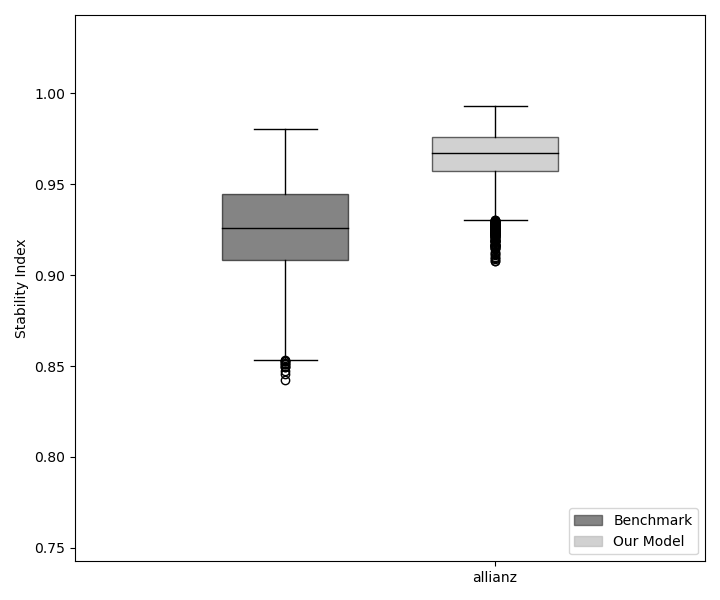

In [20]:
# Example usage
image_1 =  '../boxplots_real.png'
boxplot_stability(df_group, size=4)
#plt.savefig(image_1, bbox_inches='tight', pad_inches=0.1)  #Save the plot to a file

In [21]:
stop

NameError: name 'stop' is not defined

In [ ]:
plt.figure(figsize=(10, 20))  # Overall figure size

# First dataset
ax1 = plt.subplot(3, 2, 1, projection='3d')
plot_3d_surface(df1, 'n_estimators', 'n_feats', 'precision', ax1, fontsize_title=10, fontsize_axes=6, cmap='YlGnBu', x_step=25, y_step=50, opt_color='red', title=f'{dataset_id1}', alpha=0.85, edgecolor=None)
ax2 = plt.subplot(3, 2, 2, projection='3d')
plot_3d_surface(df1, 'n_estimators', 'n_feats', 'stability index', ax2, fontsize_title=10, fontsize_axes=6, cmap='YlGnBu', x_step=25, y_step=50, opt_color='red', title=f'{dataset_id1}', alpha=.9, edgecolor=None)

# Second dataset
ax1 = plt.subplot(3, 2, 3, projection='3d')
plot_3d_surface(df2, 'n_estimators', 'n_feats', 'precision', ax1, fontsize_title=10, fontsize_axes=6, cmap='YlGnBu', x_step=25, y_step=5, opt_color='red', title=f'{dataset_id2}', alpha=0.85, edgecolor=None)
ax2 = plt.subplot(3, 2, 4, projection='3d')
plot_3d_surface(df2, 'n_estimators', 'n_feats', 'stability index', ax2, fontsize_title=10, fontsize_axes=6, cmap='YlGnBu', x_step=25, y_step=5, opt_color='red', title=f'{dataset_id2}', alpha=.9, edgecolor=None)

# Third dataset
ax1 = plt.subplot(3, 2, 5, projection='3d')
plot_3d_surface(df3, 'n_estimators', 'n_feats', 'precision', ax1, fontsize_title=10, fontsize_axes=6, cmap='YlGnBu', x_step=25, y_step=50, opt_color='red', title=f'{dataset_id3}', alpha=0.85, edgecolor=None)
ax2 = plt.subplot(3, 2, 6, projection='3d')
plot_3d_surface(df3, 'n_estimators', 'n_feats', 'stability index', ax2, fontsize_title=10, fontsize_axes=6, cmap='YlGnBu', x_step=25, y_step=50, opt_color='red', title=f'{dataset_id3}', alpha=.9, edgecolor=None)

plt.tight_layout()  # Adjust layout


# Adjust the spacing between the plots
plt.subplots_adjust(wspace=0.1, hspace=0.1)  # Adjust the width space as needed for better visualization

#plt.savefig(image_1, bbox_inches='tight', pad_inches=0.3)  # Save the plot to a file
plt.show()